In [1]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matsim

print(pd.__version__)
print(gpd.__version__)
print(ctx.__version__)
print(matsim.__file__)


2.3.3
1.1.1
1.6.2
/opt/miniconda3/envs/jupyter_env/lib/python3.11/site-packages/matsim/__init__.py


<Axes: >

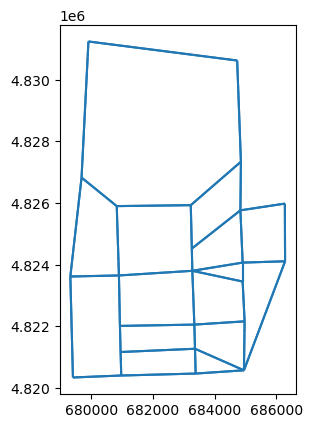

In [13]:
import matsim
import pandas as pd
from collections import defaultdict
# %matplotlib inline

# -------------------------------------------------------------------
# 1. NETWORK: Read a MATSim network:
net = matsim.read_network('scenarios/SiouxFalls/Siouxfalls_network_PT.xml')

net.nodes
# Dataframe output:
#           x        y node_id
# 0  -20000.0      0.0       1
# 1  -15000.0      0.0       2
# 2    -865.0   5925.0       3
# ...

net.links
# Dataframe output:
#      length  capacity  freespeed  ...  link_id from_node to_node
# 0   10000.0   36000.0      27.78  ...        1         1       2
# 1   10000.0    3600.0      27.78  ...        2         2       3
# 2   10000.0    3600.0      27.78  ...        3         2       4
# ...

# Extra: create a Geopandas dataframe with LINESTRINGS for our network
geo = net.as_geo()
geo.plot() # try this in a notebook to see your network!

<Axes: >

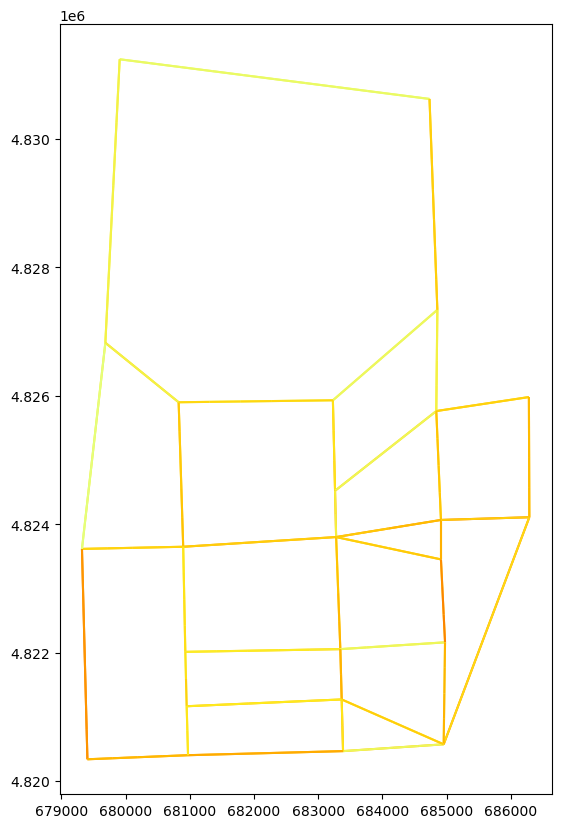

In [8]:
# -------------------------------------------------------------------
# 2. EVENTS: Stream through a MATSim event file.

# The event_reader returns a python generator function, which you can then
# loop over without loading the entire events file in memory.
#
# ---------
# Example 1: Sum up all 'entered link' events to get link volumes.
# Supports both .xml.gz and protobuf .pb.gz event file formats!
# Only returns events of type 'entered link' and 'left link':
from collections import defaultdict
events = matsim.event_reader('output/siouxfalls-2014/output_events.xml.gz', types='entered link,left link')

# defaultdict creates a blank dict entry on first reference; similar to {} but more friendly
link_counts = defaultdict(int)

for event in events:
    if event['type'] == 'entered link':
        link_counts[event['link']] += 1

# convert our link_counts dict to a pandas dataframe,
# with 'link_id' column as the index and 'count' column with value:
link_counts = pd.DataFrame.from_dict(link_counts, orient='index', columns=['count']).rename_axis('link_id')

# attach counts to our Geopandas network from above
volumes = geo.merge(link_counts, on='link_id')
volumes.plot(column='count', figsize=(10,10), cmap='Wistia') #cmap is colormap